In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import torch
import tensorflow
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.datasets import make_classification 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [3]:
df=pd.read_csv('train.csv')
census_starter=pd.read_csv('census_starter.csv')
df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100


In [4]:
census_starter

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,82.2,82.4,84.0,86.7,88.4,56037,15.3,15.2,14.8,13.7,...,0.6,0.6,1.0,0.9,1.0,71083,73008.0,74843,73384.0,76668.0
3138,83.5,85.9,87.1,89.1,90.5,56039,37.7,37.8,38.9,37.2,...,0.7,1.2,1.4,1.5,2.0,80049,83831.0,84678,87053.0,94498.0
3139,83.8,88.2,89.5,91.4,90.6,56041,11.9,10.5,11.1,12.6,...,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0,75106.0
3140,76.4,78.3,78.2,82.8,85.4,56043,15.4,15.0,15.4,15.0,...,1.3,1.0,0.9,0.9,1.1,51362,53426.0,54158,57306.0,62271.0


In [5]:
df["first_day_of_month"] = pd.to_datetime(df["first_day_of_month"])
df = df.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)
df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100


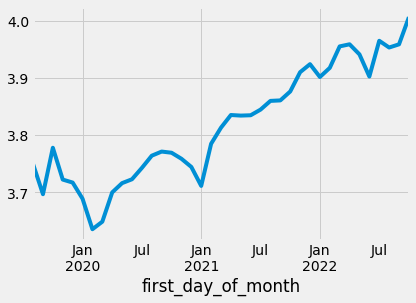

In [6]:
df.groupby(['first_day_of_month']).mean()['microbusiness_density'].plot()

In [7]:
df=(df[['cfips','first_day_of_month','microbusiness_density']].pivot('cfips', 'first_day_of_month')
   .stack(level=0)
   .rename_axis(index=['cfips', 'hour'], columns=None)
).reset_index().transpose()

df=df.drop('hour',axis=0)
df.columns=df.iloc[0]
df=df.drop('cfips',axis=0)
df

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
2019-08-01 00:00:00,3.007682,7.239156,1.073138,1.310777,1.544148,0.926372,0.674981,2.691544,1.486542,1.104277,...,1.150575,5.916088,4.062681,30.183279,6.115724,2.640386,26.433363,4.612016,2.603246,1.548594
2019-09-01 00:00:00,2.88487,7.290936,0.995794,1.305176,1.575892,0.998556,0.739265,2.703752,1.355156,1.089747,...,1.150575,5.894528,3.888567,31.712736,6.142085,2.858371,26.611856,4.338306,2.683593,1.530794
2019-10-01 00:00:00,3.055843,7.425439,1.160149,1.254761,1.546415,0.974495,0.713551,2.693764,1.355156,1.084903,...,1.150575,5.881592,3.903076,31.990431,6.181626,2.913635,26.736261,4.420419,2.635385,1.530794
2019-11-01 00:00:00,2.993233,7.426071,1.000628,1.254761,1.573625,1.022618,1.054256,2.73927,1.362664,1.084903,...,1.2006,5.954897,3.845038,32.77652,6.234348,3.008812,26.920164,4.37252,2.683593,1.601994
2019-12-01 00:00:00,2.993233,7.470274,1.000628,1.265965,1.555485,1.034649,1.054256,2.729281,1.343894,1.089747,...,1.2006,5.911776,3.845038,32.806427,6.27389,3.088637,26.903938,4.310935,2.635385,1.584194
2020-01-01 00:00:00,2.96909,7.413655,1.027229,1.253638,1.573217,1.060717,1.060871,2.719628,1.31991,1.079399,...,1.218893,5.901441,3.89026,32.847649,6.353848,3.150922,26.684565,4.367864,2.666882,1.590706
2020-02-01 00:00:00,2.909326,7.282522,1.022314,1.248041,1.536999,1.036333,1.060871,2.745211,1.331096,1.069675,...,1.26968,5.871155,3.716069,32.246933,6.486774,3.169494,26.738255,4.237172,2.699208,1.519214
2020-03-01 00:00:00,2.933231,7.30961,1.032144,1.264831,1.541526,1.060717,1.009121,2.756335,1.301268,1.074537,...,1.26968,5.897114,3.527362,32.856171,7.018477,3.237588,26.668457,4.182143,2.699208,1.537087
2020-04-01 00:00:00,3.000167,7.568799,1.086209,1.270428,1.577744,1.011948,0.996183,2.818625,1.327368,1.05995,...,1.26968,5.979319,3.469299,34.142807,6.965306,3.293302,27.119463,4.1959,2.683045,1.55496
2020-05-01 00:00:00,3.004948,7.603275,1.081294,1.287217,1.575481,0.890027,0.996183,2.834197,1.342282,1.084261,...,1.320467,6.005279,3.483815,40.916836,7.257743,3.311873,27.414764,4.443527,2.731534,1.608579


In [8]:
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults

In [9]:
df=df.fillna(method='bfill')

In [10]:
train=df[:pd.to_datetime('2022-03-01')][[1001,  1003,  1005,  1007,  1009,  1011,  1013,  1015,  1017,
             1019]]
valid=df[pd.to_datetime('2022-04-01'):][[1001,  1003,  1005,  1007,  1009,  1011,  1013,  1015,  1017,
             1019]]

In [11]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [12]:
df.columns

Int64Index([ 1001,  1003,  1005,  1007,  1009,  1011,  1013,  1015,  1017,
             1019,
            ...
            56027, 56029, 56031, 56033, 56035, 56037, 56039, 56041, 56043,
            56045],
           dtype='int64', name='cfips', length=3135)

In [14]:
model = VARMAX(np.asarray(train), order=(1,2), trend='ct') # c indicates a constant trend
results = model.fit()
results.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']",No. Observations:,32
Model:,"VARMA(1,2)",Log Likelihood,452.608
,+ intercept,AIC,-155.217
Date:,"Mon, 26 Dec 2022",BIC,394.434
Time:,19:42:27,HQIC,26.977
Sample:,0,,
,- 32,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.11, 4.12, 2.42, 0.21, 15.07, 3.60, 10.08, 0.30, 3.94, 4.51",Jarque-Bera (JB):,"1.11, 0.61, 1.05, 3.85, 0.36, 1.48, 0.75, 2.00, 0.66, 13.57"
Prob(Q):,"0.74, 0.04, 0.12, 0.65, 0.00, 0.06, 0.00, 0.59, 0.05, 0.03",Prob(JB):,"0.57, 0.74, 0.59, 0.15, 0.84, 0.48, 0.69, 0.37, 0.72, 0.00"
Heteroskedasticity (H):,"0.83, 3.63, 0.63, 2.14, 4.60, 2.38, 21.90, 3.33, 4.34, 3.71",Skew:,"-0.07, 0.30, -0.39, -0.58, 0.20, 0.51, -0.38, -0.35, 0.11, -1.13"


In [15]:
forecast=results.forecast(10)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


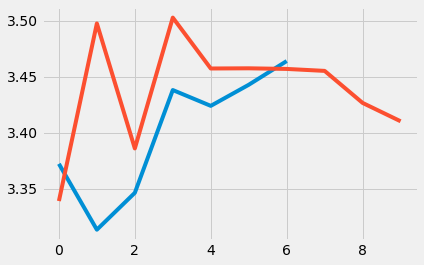

In [16]:
plt.plot(np.array(valid[1001]))
plt.plot(np.array(pd.DataFrame(forecast).iloc[:][0]))
plt.show()

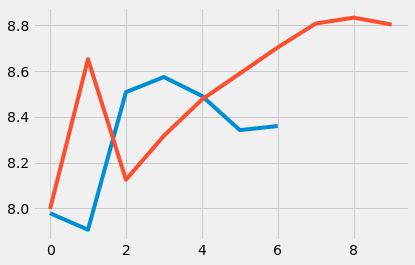

In [17]:
plt.plot(np.array(valid[1003]))
plt.plot(np.array(pd.DataFrame(forecast).iloc[:][1]))
plt.show()

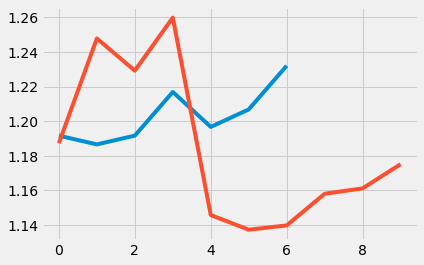

In [18]:
plt.plot(np.array(valid[1005]))
plt.plot(np.array(pd.DataFrame(forecast).iloc[:][2]))
plt.show()

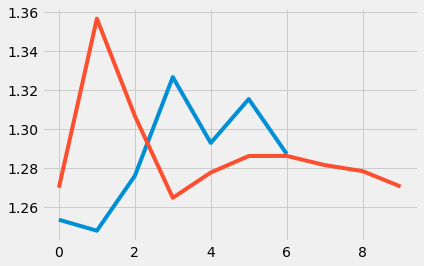

In [19]:
plt.plot(np.array(valid[1007]))
plt.plot(np.array(pd.DataFrame(forecast).iloc[:][3]))
plt.show()

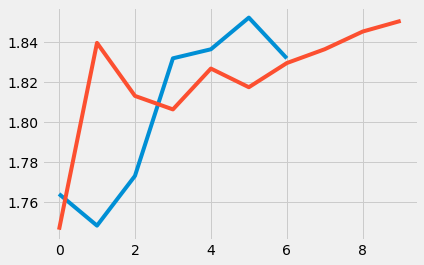

In [20]:
plt.plot(np.array(valid[1009]))
plt.plot(np.array(pd.DataFrame(forecast).iloc[:][4]))
plt.show()

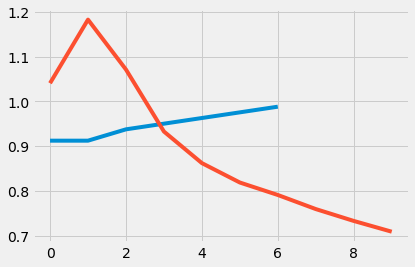

In [21]:
plt.plot(np.array(valid[1011]))
plt.plot(np.array(pd.DataFrame(forecast).iloc[:][5]))
plt.show()

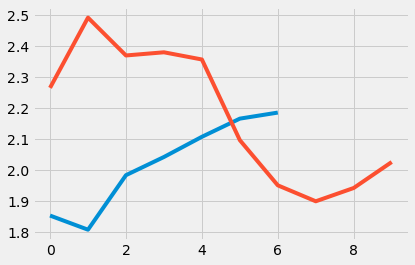

In [22]:
plt.plot(np.array(valid[1013]))
plt.plot(np.array(pd.DataFrame(forecast).iloc[:][6]))
plt.show()

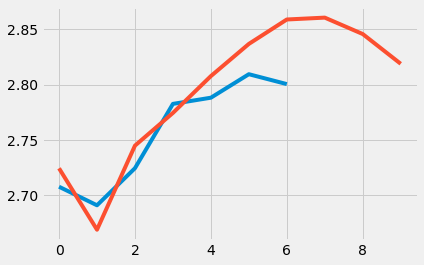

In [23]:
plt.plot(np.array(valid[1015]))
plt.plot(np.array(pd.DataFrame(forecast).iloc[:][7]))
plt.show()

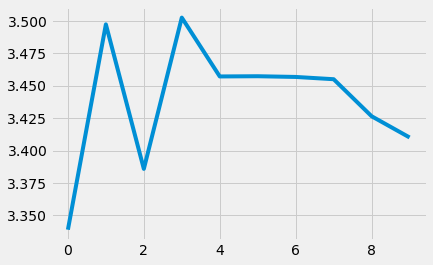

In [24]:
plt.plot(pd.DataFrame(forecast).iloc[:][0])

In [25]:
valid

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019
2022-04-01 00:00:00,3.372082,7.979170,1.191678,1.253513,1.764189,0.912085,1.853181,2.707833,1.480307,1.240966
2022-05-01 00:00:00,3.313253,7.907365,1.186629,1.247892,1.748417,0.912085,1.807504,2.691084,1.487859,1.245721
2022-06-01 00:00:00,3.346197,8.507496,1.191678,1.275998,1.773202,0.937421,1.983687,2.724583,1.468978,1.117345
2022-07-01 00:00:00,3.437971,8.573463,1.216926,1.326588,1.831783,0.950089,2.042414,2.782648,1.548280,1.141118
2022-08-01 00:00:00,3.423852,8.491150,1.196728,1.292861,1.836289,0.962757,2.107667,2.788231,1.521846,1.131609
2022-09-01 00:00:00,3.442677,8.341701,1.206827,1.315346,1.852060,0.975424,2.166395,2.809447,1.502964,1.131609
2022-10-01 00:00:00,3.463856,8.359798,1.232074,1.287240,1.831783,0.988092,2.185970,2.800514,1.442544,1.117345


In [ ]:
train